### Trabalho PySpark

Autores:

- Igor da Silva Cassolli
- Jones Marlos Pinheiro da Rosa

### Importando Bibliotecas

In [392]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### Iniciando sessão Spark

In [393]:
spark = SparkSession.builder.appName('Trabalho-PySpark').getOrCreate()

### Criando estrutura de dados

In [394]:
from pyspark.sql.types import StructType, StructField, FloatType, StringType, DateType, IntegerType, TimestampType

# Criando schema com os tipos de cada coluna do dataset
schema = StructType([
    StructField("data_extracao", TimestampType(), nullable=True), 
    StructField("predial1", IntegerType(), nullable=True),
    StructField("queda_arr", FloatType(), nullable=True),
    StructField("data", DateType(), nullable=True),
    StructField("feridos", IntegerType(), nullable=True),
    StructField("feridos_gr", IntegerType(), nullable=True),
    StructField("mortes", IntegerType(), nullable=True),
    StructField("morte_post", IntegerType(), nullable=True),
    StructField("fatais", IntegerType(), nullable=True),
    StructField("auto", IntegerType(), nullable=True),
    StructField("taxi", IntegerType(), nullable=True),
    StructField("lotacao", IntegerType(), nullable=True),
    StructField("onibus_urb", IntegerType(), nullable=True),
    StructField("onibus_met", IntegerType(), nullable=True),
    StructField("onibus_int", IntegerType(), nullable=True),
    StructField("caminhao", IntegerType(), nullable=True),
    StructField("moto", IntegerType(), nullable=True),
    StructField("carroca", IntegerType(), nullable=True),
    StructField("bicicleta", IntegerType(), nullable=True),
    StructField("outro", IntegerType(), nullable=True),
    StructField("cont_vit", IntegerType(), nullable=True),
    StructField("ups", IntegerType(), nullable=True),
    StructField("patinete", IntegerType(), nullable=True),
    StructField("idacidente", IntegerType(), nullable=True),
    StructField("longitude", StringType(), nullable=True),
    StructField("latitude", StringType(), nullable=True),
    StructField("log1", StringType(), nullable=True),
    StructField("log2", StringType(), nullable=True),
    StructField("tipo_acid", StringType(), nullable=True),
    StructField("dia_sem", StringType(), nullable=True),
    StructField("hora", StringType(), nullable=True),
    StructField("noite_dia", StringType(), nullable=True),
    StructField("regiao", StringType(), nullable=True),
    StructField("consorcio", StringType(), nullable=True),
])

# Lendo dataset com base no schema criado
data_acidentes = spark.read.csv("dataset_acidentes.csv", schema=schema, header=True, sep=";")

# Criar tabela temporária para rodar comandos SQL
data_acidentes.createOrReplaceTempView("acidentes_table")

### Analisar os dados

In [395]:
#Exibindo os 10 primeiros registros
data_acidentes.show(1)

+-------------------+--------+---------+----------+-------+----------+------+----------+------+----+----+-------+----------+----------+----------+--------+----+-------+---------+-----+--------+---+--------+----------+---------+--------+----------------+----------------+------------+-------+----------------+---------+------+---------+
|      data_extracao|predial1|queda_arr|      data|feridos|feridos_gr|mortes|morte_post|fatais|auto|taxi|lotacao|onibus_urb|onibus_met|onibus_int|caminhao|moto|carroca|bicicleta|outro|cont_vit|ups|patinete|idacidente|longitude|latitude|            log1|            log2|   tipo_acid|dia_sem|            hora|noite_dia|regiao|consorcio|
+-------------------+--------+---------+----------+-------+----------+------+----------+------+----+----+-------+----------+----------+----------+--------+----+-------+---------+-----+--------+---+--------+----------+---------+--------+----------------+----------------+------------+-------+----------------+---------+------+---

In [396]:
#Transformando nossos dados em formato pandas
df = data_acidentes.toPandas()

In [397]:
np.unique(df['mortes'], return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([72736,   204,     8,     1]))

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72949 entries, 0 to 72948
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data_extracao  72949 non-null  datetime64[ns]
 1   predial1       20000 non-null  float64       
 2   queda_arr      72949 non-null  float32       
 3   data           72949 non-null  object        
 4   feridos        72949 non-null  int32         
 5   feridos_gr     72949 non-null  int32         
 6   mortes         72949 non-null  int32         
 7   morte_post     72949 non-null  int32         
 8   fatais         72949 non-null  int32         
 9   auto           72949 non-null  int32         
 10  taxi           72949 non-null  int32         
 11  lotacao        72949 non-null  int32         
 12  onibus_urb     72949 non-null  int32         
 13  onibus_met     72949 non-null  int32         
 14  onibus_int     72949 non-null  int32         
 15  caminhao       7294

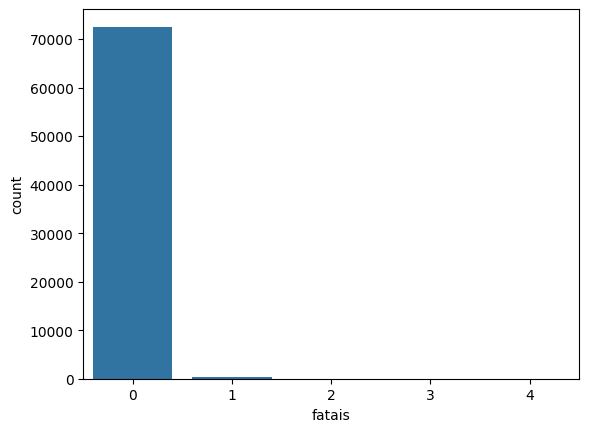

In [399]:
# Gráfico número de mortes
sns.countplot(x='fatais', data=df)
plt.show()

In [400]:
# Select para visualizar melhor o número de mortes
spark.sql("SELECT mortes, count(acidentes_table.idacidente) as quantidade FROM acidentes_table GROUP BY mortes").show()

+------+----------+
|mortes|quantidade|
+------+----------+
|     1|       204|
|     2|         8|
|     0|     72736|
|     3|         1|
+------+----------+



In [401]:
# Select para visualizar o total de mortes, ** fatais soma a coluna mortes e mortes_post **
spark.sql("SELECT fatais, count(acidentes_table.idacidente) as quantidade FROM acidentes_table GROUP BY fatais").show()

+------+----------+
|fatais|quantidade|
+------+----------+
|     1|       395|
|     2|        10|
|     0|     72542|
|     3|         1|
|     4|         1|
+------+----------+



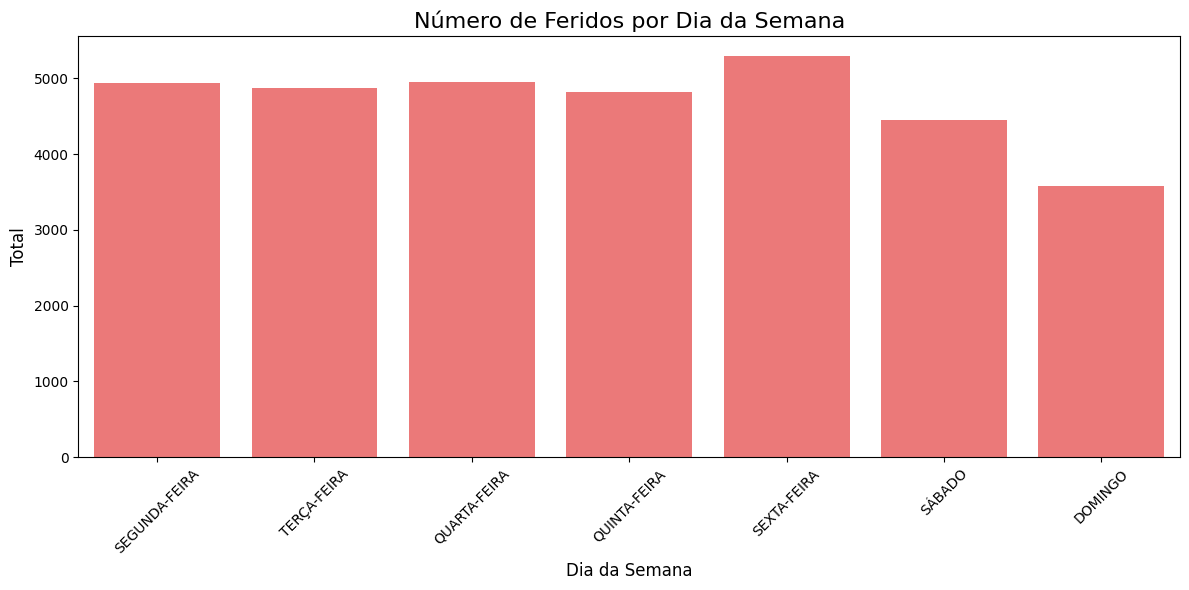

In [402]:
dias_semana_order = ["SEGUNDA-FEIRA", "TERÇA-FEIRA", "QUARTA-FEIRA", 
                     "QUINTA-FEIRA", "SEXTA-FEIRA", "SÁBADO", "DOMINGO"]

df_grouped = df.groupby("dia_sem").agg({"feridos": "sum"}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_grouped, x="dia_sem", y="feridos", color="red", alpha=0.6, order=dias_semana_order)
plt.title("Número de Feridos por Dia da Semana", fontsize=16)
plt.xlabel("Dia da Semana", fontsize=12)
plt.ylabel("Total", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [403]:
# Select para visualizar a quantidade de feridos e de mortes por tipo de acidente
spark.sql("SELECT tipo_acid, sum(acidentes_table.fatais) as quantidade_mortes, sum(acidentes_table.feridos) as quantidade_feridos"+
           " FROM acidentes_table GROUP BY tipo_acid").show()

+--------------+-----------------+------------------+
|     tipo_acid|quantidade_mortes|quantidade_feridos|
+--------------+-----------------+------------------+
|  ABALROAMENTO|              104|             14056|
|NAO CADASTRADO|                1|              1894|
|      INCÊNDIO|                0|                 3|
| ATROPELAMENTO|              142|              4186|
|        CHOQUE|              103|              2362|
|    TOMBAMENTO|                1|                67|
|     CAPOTAGEM|                7|               245|
|      EVENTUAL|                0|               451|
|         QUEDA|               28|              2213|
|       COLISÃO|               36|              7439|
+--------------+-----------------+------------------+



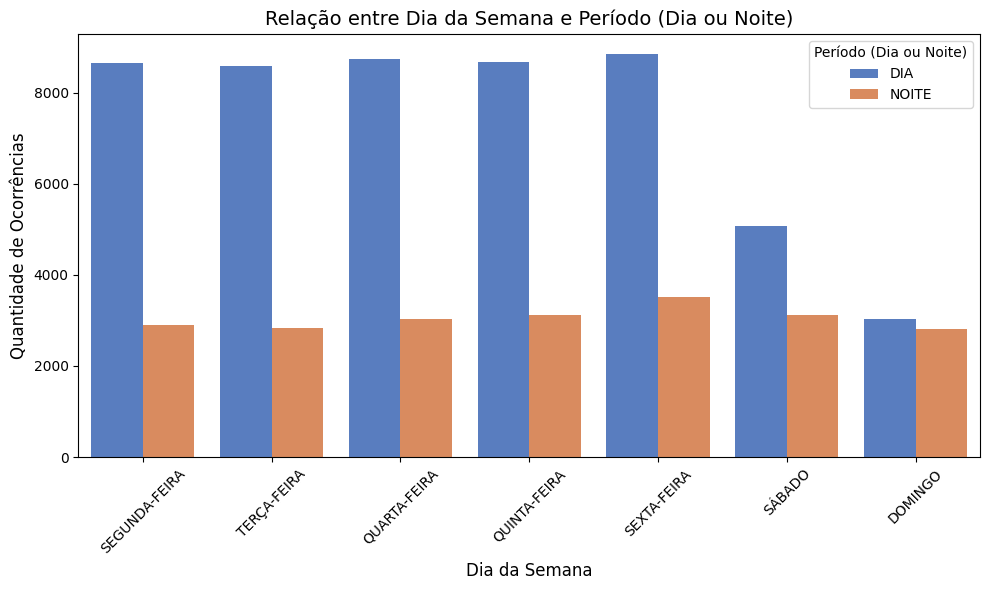

In [404]:
dias_semana_order = ["SEGUNDA-FEIRA", "TERÇA-FEIRA", "QUARTA-FEIRA", 
                     "QUINTA-FEIRA", "SEXTA-FEIRA", "SÁBADO", "DOMINGO"]

contagem = df.groupby(["dia_sem", "noite_dia"]).size().reset_index(name="quantidade")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=contagem,
    x="dia_sem",
    y="quantidade",
    hue="noite_dia",
    palette="muted",
    order=dias_semana_order
)
plt.title("Relação entre Dia da Semana e Período (Dia ou Noite)", fontsize=14)
plt.xlabel("Dia da Semana", fontsize=12)
plt.ylabel("Quantidade de Ocorrências", fontsize=12)
plt.legend(title="Período (Dia ou Noite)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Explicar os dados

In [405]:
df.describe()

,data_extracao,predial1,queda_arr,feridos,feridos_gr,mortes,morte_post,fatais,auto,taxi,...,onibus_int,caminhao,moto,carroca,bicicleta,outro,cont_vit,ups,patinete,idacidente
count,72949,20000.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,...,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000,72949.000000
mean,2024-09-01 01:32:35.999999744,1515.566450,0.000507,0.451219,0.080316,0.003057,0.002728,0.005785,1.436168,0.018547,...,0.008883,0.083483,0.312259,0.000329,0.020124,0.001179,0.386599,2.591029,0.000233,698894.691771
min,2024-09-01 01:32:36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,190816.000000
25%,2024-09-01 01:32:36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,674319.000000
50%,2024-09-01 01:32:36,565.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,692695.000000
75%,2024-09-01 01:32:36,1990.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,730899.000000
max,2024-09-01 01:32:36,90010.000000,1.000000,34.000000,5.000000,3.000000,2.000000,4.000000,10.000000,2.000000,...,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,1.000000,13.000000,2.000000,749141.000000
std,NaN,2364.588506,0.022516,0.670259,0.294352,0.057872,0.052682,0.079198,0.766656,0.135832,...,0.094122,0.285394,0.491023,0.018135,0.141978,0.035105,0.486974,2.090074,0.016137,29118.598853


In [406]:
# Select para visualizar a quantidade de vitimas fatais, feridos e cont_vit para visualizar a diferença
spark.sql("SELECT mortes, morte_post, fatais, feridos, cont_vit  FROM acidentes_table GROUP BY mortes, morte_post, fatais, feridos, cont_vit").show()

# ********** IDENTIFICADO QUE FATAIS É A SOMA DE MORTES E MORTE_POST ************
# ********** NÚMERO DE VITIMAS PARECE SER VITIMAS QUE PODEM TER SE ENVOLDIDO NO ACIDENTE, MAS NÃO NECESSARIAMENTE MORREU OU SE FERIU ************

+------+----------+------+-------+--------+
|mortes|morte_post|fatais|feridos|cont_vit|
+------+----------+------+-------+--------+
|     0|         0|     0|      0|       0|
|     2|         0|     2|      1|       1|
|     2|         0|     2|      0|       1|
|     0|         1|     1|      1|       1|
|     0|         0|     0|      3|       1|
|     0|         1|     1|      3|       1|
|     1|         0|     1|      2|       1|
|     1|         0|     1|      3|       1|
|     1|         0|     1|      4|       1|
|     0|         1|     1|      0|       1|
|     0|         0|     0|      2|       1|
|     0|         0|     0|      1|       1|
|     0|         0|     0|     25|       1|
|     0|         1|     1|      2|       1|
|     0|         2|     2|      0|       1|
|     0|         0|     0|      6|       1|
|     0|         0|     0|      4|       1|
|     1|         0|     1|      0|       1|
|     1|         0|     1|      1|       1|
|     0|         0|     0|      

In [407]:
# Select para visualizar a coluna ups que é um dado numérico para gravidade do acidente
spark.sql("SELECT DISTINCT ups from acidentes_table").show()
spark.sql("SELECT ups, mortes, morte_post, fatais, feridos, cont_vit  FROM acidentes_table GROUP BY ups, mortes, morte_post, fatais, feridos, cont_vit").show()

print(df['ups'].value_counts())

+---+
|ups|
+---+
|  1|
| 13|
|  5|
+---+

+---+------+----------+------+-------+--------+
|ups|mortes|morte_post|fatais|feridos|cont_vit|
+---+------+----------+------+-------+--------+
| 13|     0|         1|     1|      3|       1|
| 13|     1|         0|     1|      1|       1|
|  5|     0|         0|     0|      1|       1|
| 13|     0|         1|     1|      1|       1|
|  5|     0|         0|     0|      4|       1|
|  1|     0|         0|     0|      0|       0|
|  5|     0|         0|     0|      7|       1|
| 13|     1|         0|     1|      3|       1|
|  5|     0|         0|     0|     25|       1|
| 13|     0|         2|     2|      0|       1|
| 13|     2|         0|     2|      1|       1|
| 13|     1|         0|     1|      0|       1|
| 13|     0|         1|     1|      0|       1|
|  5|     0|         0|     0|      6|       1|
| 13|     0|         1|     1|      2|       1|
| 13|     2|         0|     2|      0|       1|
|  5|     0|         0|     0|      3|       

#### Descrição das colunas:

In [408]:
df.dtypes

data_extracao    datetime64[ns]
predial1                float64
queda_arr               float32
data                     object
feridos                   int32
feridos_gr                int32
mortes                    int32
morte_post                int32
fatais                    int32
auto                      int32
taxi                      int32
lotacao                   int32
onibus_urb                int32
onibus_met                int32
onibus_int                int32
caminhao                  int32
moto                      int32
carroca                   int32
bicicleta                 int32
outro                     int32
cont_vit                  int32
ups                       int32
patinete                  int32
idacidente                int32
longitude                object
latitude                 object
log1                     object
log2                     object
tipo_acid                object
dia_sem                  object
hora                     object
noite_di

- data_extracao -> Data que foi importado os registros para o dataset público
- predial1 -> Número do edificio
- queda_arr -> Se o veículo caiu em algum riacho/rio
- data -> Data do acidente
- feridos -> Número de feridos
- feridos_gr -> Número de gravemente feridos
- mortes -> Número de mortes
- morte_post -> Número de mortes posteriormente
- fatais -> Número total de mortes (somando mortes e morte_post)
- auto -> Número de carros
- taxi -> Número de taxi
- lotacao -> Número de lotação
- onibus_urb -> Número de ônibus urbanos
- onibus_met -> Número de ônibus de outras cidades
- onibus_int -> Número de ônibus intermunicipais
- caminhao -> Número de caminhões 
- moto -> Número de motos
- carroca -> Número de carroças
- bicicleta -> Número de bicicletas
- outro -> Número de outros veículos diferente dos que estão listados anteriormente
- cont_vit -> Número de vitimas
- ups -> Unidade de gravidade padrão: Peso atribuído aos tipos de acidentes de acordo com a gravidade dos danos causados
- patinete -> Número de patinetes
- idacidente -> Id do acidente
- longitude -> Longitude do local do endereço
- latitude -> Latitude do local do endereço
- log1 -> Endereço do acidente
- log2 -> Complemente do endereço
- tipo_acid -> Tipo do acidente
- dia_sem -> Dia da semana que ocorreu o acidente
- hora -> Hora do acidente
- noite_dia -> Coluna que sinaliza se o acidente ocorreu durante o DIA ou NOITE
- regiao -> Região que ocorreu o acidente
- consorcio -> Consorcio do ônibus

### Decidir quais atributos serão úteis

In [409]:
# Excluir colunas desnecessarias
df.drop(columns=['data_extracao', 'predial1', 'queda_arr', 'data', 'feridos', 'feridos_gr', 'mortes', 'morte_post', 'fatais', 'auto', 'taxi', 'moto', 'lotacao', 'onibus_urb', 'onibus_met', 'onibus_int',
                 'caminhao', 'carroca', 'bicicleta', 'outro', 'cont_vit', 'patinete', 'idacidente', 'log1', 'log2', 'tipo_acid', 'hora', 'regiao', 'consorcio'], inplace=True)

### Classificar as variáveis/atributo

In [410]:
df.describe()

,ups
count,72949.000000
mean,2.591029
std,2.090074
min,1.000000
25%,1.000000
50%,1.000000
75%,5.000000
max,13.000000


In [411]:
df.describe(include='object')

,longitude,latitude,dia_sem,noite_dia
count,62743,62743,72949,72949
unique,43541,44906,7,2
top,0,0,SEXTA-FEIRA,DIA
freq,594,594,12373,51611


In [412]:
#Criar coluna de gravidade em cima do valor de ups
def classificar_gravidade(ups):
    if ups <= 3:
        return "BAIXA"
    elif 4 <= ups <= 10:
        return "MEDIA"
    else:
        return "ALTA"

# Criar a nova coluna
df["gravidade_acidente"] = df["ups"].apply(classificar_gravidade)

df.drop(columns=['ups'], inplace=True)

### Transformar as colunas

In [413]:
# Codificar o dia da semana entre 0 e 6
def encoder_dia_semana(dia):
  case = {
      "DOMINGO": 0,
      "SEGUNDA-FEIRA": 1,
      "TERÇA-FEIRA": 2,
      "QUARTA-FEIRA": 3,
      "QUINTA-FEIRA": 4,
      "SEXTA-FEIRA": 5,
      "SÁBADO": 6
  }
  return case[dia] / 6

df["dia_sem"] = df["dia_sem"].apply(encoder_dia_semana)


In [414]:
# Codificar o dia/noite em 0 e 1
def encoder_noite_dia(noite):
  case = {
      "DIA": 0,
      "NOITE": 1
  }
  return case[noite]

df["noite_dia"] = df["noite_dia"].apply(encoder_noite_dia)

### Padronizar os dados

In [415]:
df["longitude"]

0                          0
1                 -817840587
2                 -826760803
3                 -827227451
4                 -820146494
                ...         
72944     -51.12389359458912
72945     -51.15155178808491
72946    -51.214687122029076
72947    -51.170429198072945
72948    -51.221553807567005
Name: longitude, Length: 72949, dtype: object

In [416]:
# Ajustar os valores de latitude e longitude para ficar dentro dos valores esperados
def ajustar_latlong(val):
  if val == None:
    return np.nan
  val = val.replace(',', '.')
  val = float(val)
  if val > 180 or val < -180:
    return np.nan
  else:
    return val / 180

df["latitude"] = df["latitude"].apply(ajustar_latlong)
df["longitude"] = df["longitude"].apply(ajustar_latlong)

In [417]:
df.dropna(axis=0, inplace=True)

### Separar entre previsores e classe

In [418]:
df.dtypes

longitude             float64
latitude              float64
dia_sem               float64
noite_dia               int64
gravidade_acidente     object
dtype: object

In [419]:
df

,longitude,latitude,dia_sem,noite_dia,gravidade_acidente
0,0.000000,0.000000,1.0,1,MEDIA
6,-0.284451,-0.166664,0.5,0,MEDIA
8,-0.284491,-0.167081,0.5,0,MEDIA
11,-0.284574,-0.167240,0.5,0,MEDIA
13,-0.284146,-0.166902,0.5,1,MEDIA
...,...,...,...,...,...
72944,-0.284022,-0.166795,1.0,1,MEDIA
72945,-0.284175,-0.166793,1.0,1,MEDIA
72946,-0.284526,-0.167077,0.0,1,MEDIA
72947,-0.284280,-0.166894,0.0,1,BAIXA


In [420]:
x_acidentes = df.iloc[:, :4].values
y_acidentes = df.iloc[:, 4].values

### Dividir entre conjuntos de treino e teste

In [421]:
from sklearn.model_selection import train_test_split

x_acidentes_treino, x_acidentes_teste, y_acidentes_treino, y_acidentes_teste = train_test_split(x_acidentes, y_acidentes, test_size=0.2)

### Treinar um modelo de machine learning

In [422]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_acidentes_treino, y_acidentes_treino)

RandomForestClassifier(random_state=42)

### Reportar os resultados estatísticos

In [423]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_acidentes_teste)
accuracy = accuracy_score(y_acidentes_teste, y_pred)
print(f'Acurácia: {accuracy}')

Acurácia: 0.6121539628365567


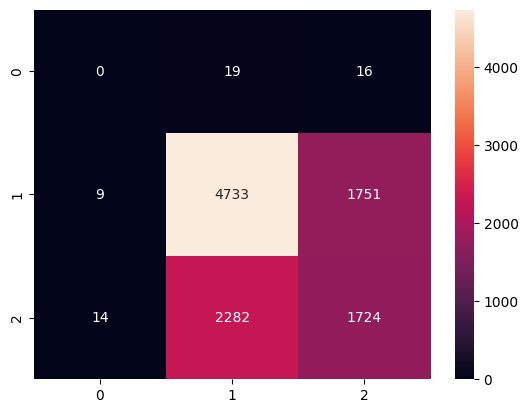

In [427]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_acidentes_teste, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

### Importar Modelo

In [425]:
import pickle
pickle.dump(model, open('final_classification_model.pkl', 'wb'))